In [264]:
import torch
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
from torch import randn
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn

import random, os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

%matplotlib inline

In [265]:
def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [266]:
def dy_dx(y, x):
  return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def d2y_dx2(y, x):
  return dy_dx(dy_dx(y,x), x)

def d3y_dx3(y, x):
  return dy_dx(d2y_dx2(y,x), x)

#CHECK
def d2x_dx2(x):
  return dy_dx(dy_dx(x, 0), 0)

In [267]:
domain = [0, 10]
n_discretization = 10 * domain[1] - domain[0]

In [268]:
n_input = 1
n_output = 1
eps = 1e-10

In [269]:
x = torch.linspace(domain[0] + eps, domain[1] - eps, n_discretization).reshape(-1,1)
x = Variable(x, requires_grad=True).double()

In [270]:
mlp = nn.Sequential(
  nn.Linear(n_input, 32),
  nn.Tanh(),
  nn.Linear(32, 64),
  nn.Tanh(),
  nn.Linear(64, 128),
  nn.Tanh(),
  nn.Linear(128, 64),
  nn.Tanh(),        
  nn.Linear(64, 16),
  nn.Linear(16, n_output)
).double()

In [271]:
def get_loss(x, ret_res=False):    
  y = mlp(x)
  y_x = dy_dx(y, x)
  y_xx = dy_dx(y_x, x)
  y_xxx = dy_dx(y_xx, x)


  """    
  Blasius Eq.: 
   f''' + 0.5 ff'' = 0
   2f''' + ff'' = 0   ,   f(0) = f'(0) = 0, f'(∞) = 1
  """
  
  residual = (2 * y_xxx) + (y_xx * y)


  # boundaries same for all equations
  boundary1 = y[0]
  boundary2 = y_x[0]
  boundary3 = y_x[-1] - 1

  loss = (residual**2).mean() + boundary1**2 + boundary2**2 + boundary3**2
  return (loss, residual) if ret_res else loss

In [272]:
def closure():
  loss = get_loss(x)
  optimizer.zero_grad()
  loss.backward()
  return loss

In [281]:
#TODO
optimizer = optim.Adam(list(mlp.parameters()), lr=0.01, betas=(0.9, 0.999), eps=1e-32)
previous = 0
losses = []
epoch_Adam = 100
epoch_LBFGS = 2000
for i in range(epoch_Adam):
  loss = get_loss(x)
  
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i, loss))        
  
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.detach().numpy())


optimizer = optim.LBFGS(list(mlp.parameters()), lr = 0.01)
previous = 0
for i in range(epoch_LBFGS):
  loss = get_loss(x)
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i+epoch_Adam, loss))
    if abs(previous - loss) < 1e-10:
        print('converged')
        break
    
    previous = loss
  
  losses.append(loss.detach().numpy())
  optimizer.step(closure)

print("Final loss = %.2e" % get_loss(x))

Step: 000 loss = 00000.0022492227
Step: 002 loss = 00001.3789126825
Step: 004 loss = 00000.9977518938
Step: 006 loss = 00000.9842240048
Step: 008 loss = 00000.9902135877
Step: 010 loss = 00000.9933404209
Step: 012 loss = 00000.9927531485
Step: 014 loss = 00000.9936650460
Step: 016 loss = 00000.9954417364
Step: 018 loss = 00000.9946526900
Step: 020 loss = 00000.9936955633
Step: 022 loss = 00000.9937566899
Step: 024 loss = 00000.9930488616
Step: 026 loss = 00000.9914482483
Step: 028 loss = 00000.9890388042
Step: 030 loss = 00000.9858185007
Step: 032 loss = 00000.9806282169
Step: 034 loss = 00000.9717769305
Step: 036 loss = 00000.9596263194
Step: 038 loss = 00000.9478905218
Step: 040 loss = 00000.9388446330
Step: 042 loss = 00000.8575965292
Step: 044 loss = 00000.8688282340
Step: 046 loss = 00000.7007970476
Step: 048 loss = 00000.5114452505
Step: 050 loss = 00000.3329006210
Step: 052 loss = 00001.1492669653
Step: 054 loss = 00000.8243792008
Step: 056 loss = 00000.9498548002
Step: 058 loss

In [282]:
pd.options.display.float_format = '{:.16f}'.format
domain_test = torch.tensor([0.00,0.10,0.20,0.50,1.00,1.50,2.00], dtype=torch.double).reshape(-1,1)
predict_test = mlp.forward(domain_test).detach().numpy().flatten()
pd.DataFrame(np.array([domain_test.numpy().flatten(), predict_test]).T, columns=['x','y'])

,x,y
0,0.0000000000000000,0.0000130086133853
1,0.1000000000000000,0.0016743493110084
2,0.2000000000000000,0.0066558225792566
3,0.5000000000000000,0.0414935795941099
4,1.0000000000000000,0.1655428536099108
5,1.5000000000000000,0.3700842400863761
6,2.0000000000000000,0.6499042038221765


In [284]:
# calculate f''(0)

# make zero Tensor from x Tensor
zerox = x.clone()
zerox[0][0] = 0
zero = zerox[0]
f_xx_0 = d2y_dx2(mlp(zero), zero)
print("f''(0) = {}".format(f_xx_0[0]))

# history 
# f''(0) = 0.3325398571314273
# f''(0) = 0.3321312229973239

f''(0) = 0.3321312229973239


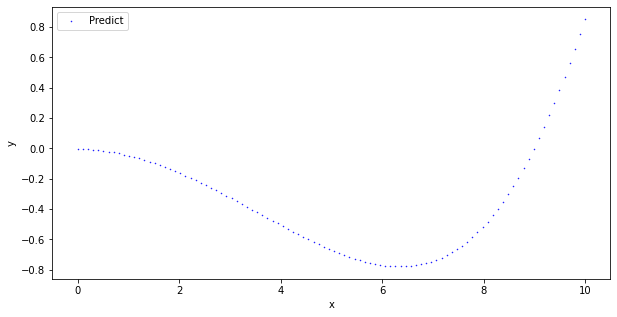

In [276]:
#[TODO]
domain = x.detach().numpy().flatten()
# exact = (1 - x**2 / 6).detach().numpy().flatten()
predict = mlp.forward(x).detach().numpy().flatten()

plt.figure(figsize=(10, 5))
plt.xlabel('x')
plt.ylabel('y')

# plt.plot(domain, exact,'k--', markersize=.1, label='Exact')
plt.plot(domain, predict,'b.', markersize=1, label='Predict')
plt.legend()

# plt.savefig('exact-predict.eps', bbox_inches='tight', format='eps')

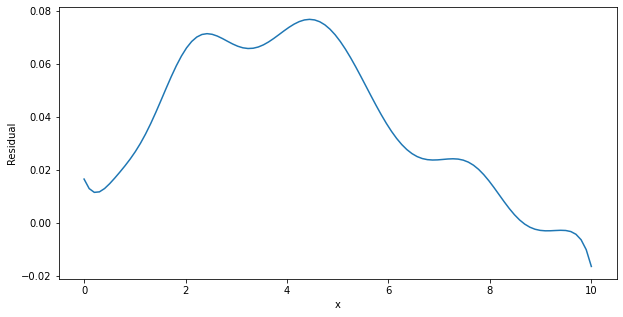

In [277]:
plt.figure(figsize=(10, 5))

res= get_loss(x, ret_res=True)[1].detach().numpy()
plt.xlabel('x')
plt.ylabel('Residual')
plt.plot(domain, res)
plt.savefig('residual-loss.eps', bbox_inches='tight', format='eps')

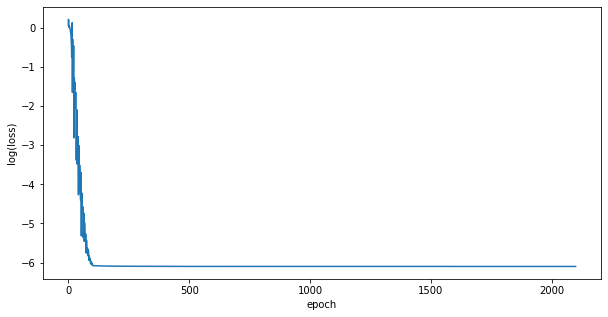

In [278]:
plt.figure(figsize=(10, 5))
plt.plot(np.log(losses))
plt.xlabel('epoch')
plt.ylabel('log(loss)')

plt.savefig('loss.eps', bbox_inches='tight', format='eps')